In [1]:
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_addons as tfa
import cv2
from skimage import io, color
from tensorflow.data import AUTOTUNE

import time

from IPython import display

%matplotlib inline

In [2]:
tf.__version__

'2.10.1'

In [3]:
# data path 

face_path = r"D:\data\cartoonset10k_rgb"

In [4]:
images = os.listdir(path=face_path)
images = [os.path.join(face_path, image) for image in images if image.endswith(".jpg")]

In [5]:
len(images)

10000

In [6]:
train_images = images[:18000]
test_images = images[18000:]

In [7]:
width = 128
height = 128

In [8]:
import math

class cartoonGen(tf.keras.utils.Sequence):
    
    def __init__(self, img_paths, batch_size):
        self.img_paths = img_paths
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)
    
    def get_segmented_image(self,img):
        
        # print("image shape ", img.shape)
        img = cv2.resize(img, (width, height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pixel_values = np.float32( img.reshape((-1, 3)) )
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        k = 3
        _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        labels = labels.flatten()

        centers = np.uint8(centers)
        centers
        segmented_image = centers[labels.flatten()]
        segmented_image = segmented_image.reshape(img.shape)
        # show the image
        return img, segmented_image
        
    

    def __getitem__(self, idx):
        batch_x = self.img_paths[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        bx1, bx2 = [], []
        
        for x in batch_x:
            # print("x val", x)
            img = cv2.imread(x)
            img, segmented_img = self.get_segmented_image(img)
            bx1.append(img)
            bx2.append(segmented_img)
            

        return np.array(bx2),np.array(bx1)
    

In [9]:
train_ds  = cartoonGen(train_images,16)
val_df = cartoonGen(test_images,16)

In [10]:
image_batch, label_batch = next(iter(train_ds))

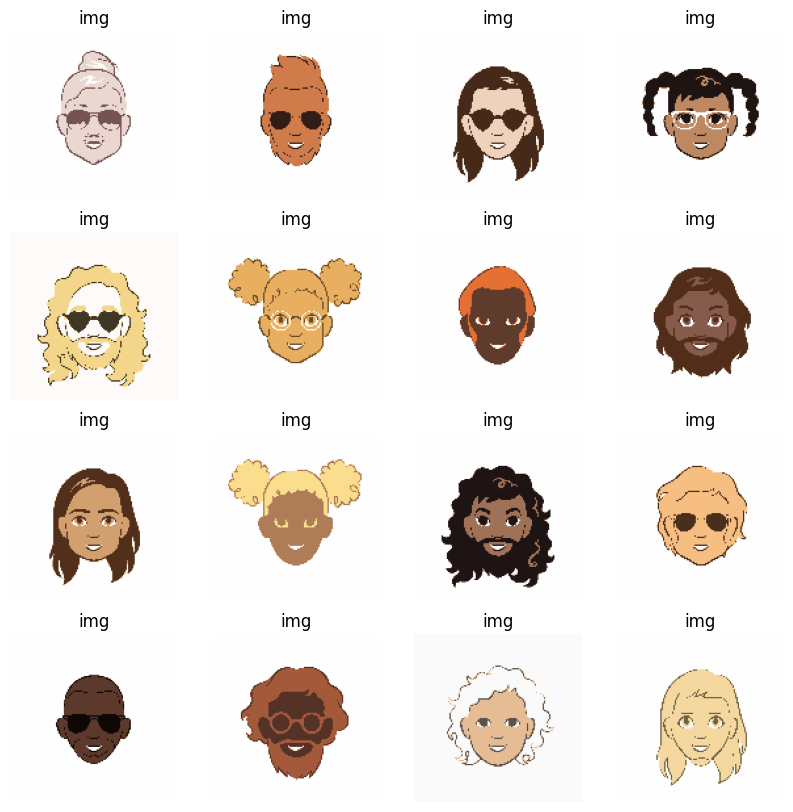

In [11]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = image_batch[i]
  # print(img.max())
  # img *= 255
  # i = i.astype("uint8")
  plt.imshow(img)
#   label = label_batch[i]
  plt.title("img")
  plt.axis("off")

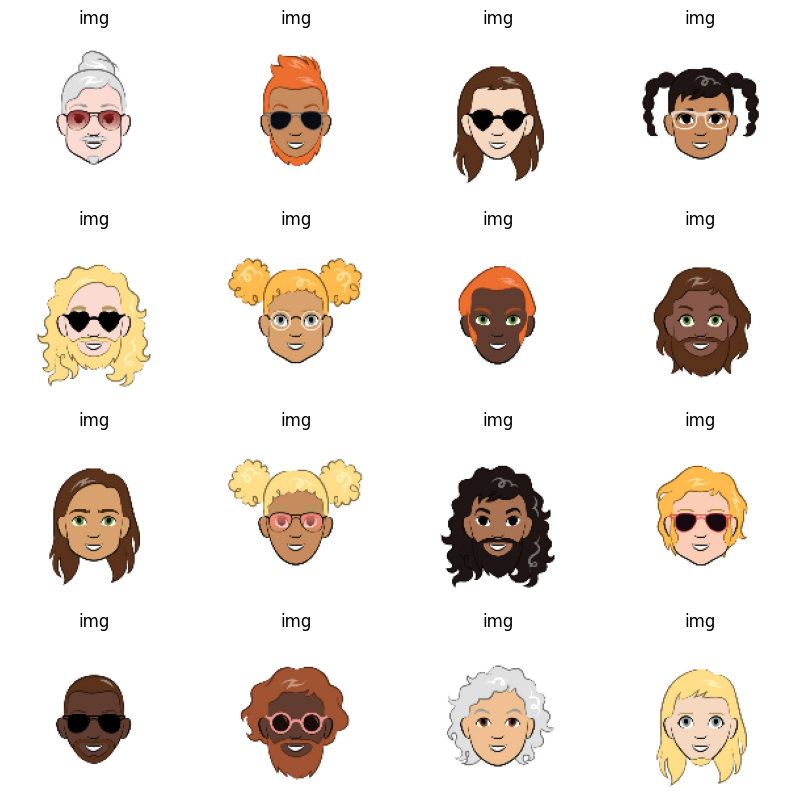

In [12]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = label_batch[i]
  # print(img.max())
  # img *= 255
  # i = i.astype("uint8")
  plt.imshow(img)
#   label = label_batch[i]
  plt.title("img")
  plt.axis("off")

In [13]:
image_batch[0].shape, label_batch[0].shape

((128, 128, 3), (128, 128, 3))

In [14]:
# Build A DC GAN model 

In [15]:
# Build encoder decoder model using keras functional API

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(128, 128, 3)))
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'))
    
    
    return model

generator = make_generator_model()
generator.summary()


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# Discriminator loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,out_images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(images, training=True)

      real_output = discriminator(out_images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [25]:
import time

def generate_and_save_images(model, epoch, img_1, img2):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(img_1, training=False)

  fig = plt.figure(figsize=(80, 80))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      
      plt.imshow(predictions[i]) # * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for img1,img2 in dataset:
      # print(img1.shape, img2.shape)
      train_step(img1,img2)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             img1,img2)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           img1,img2)

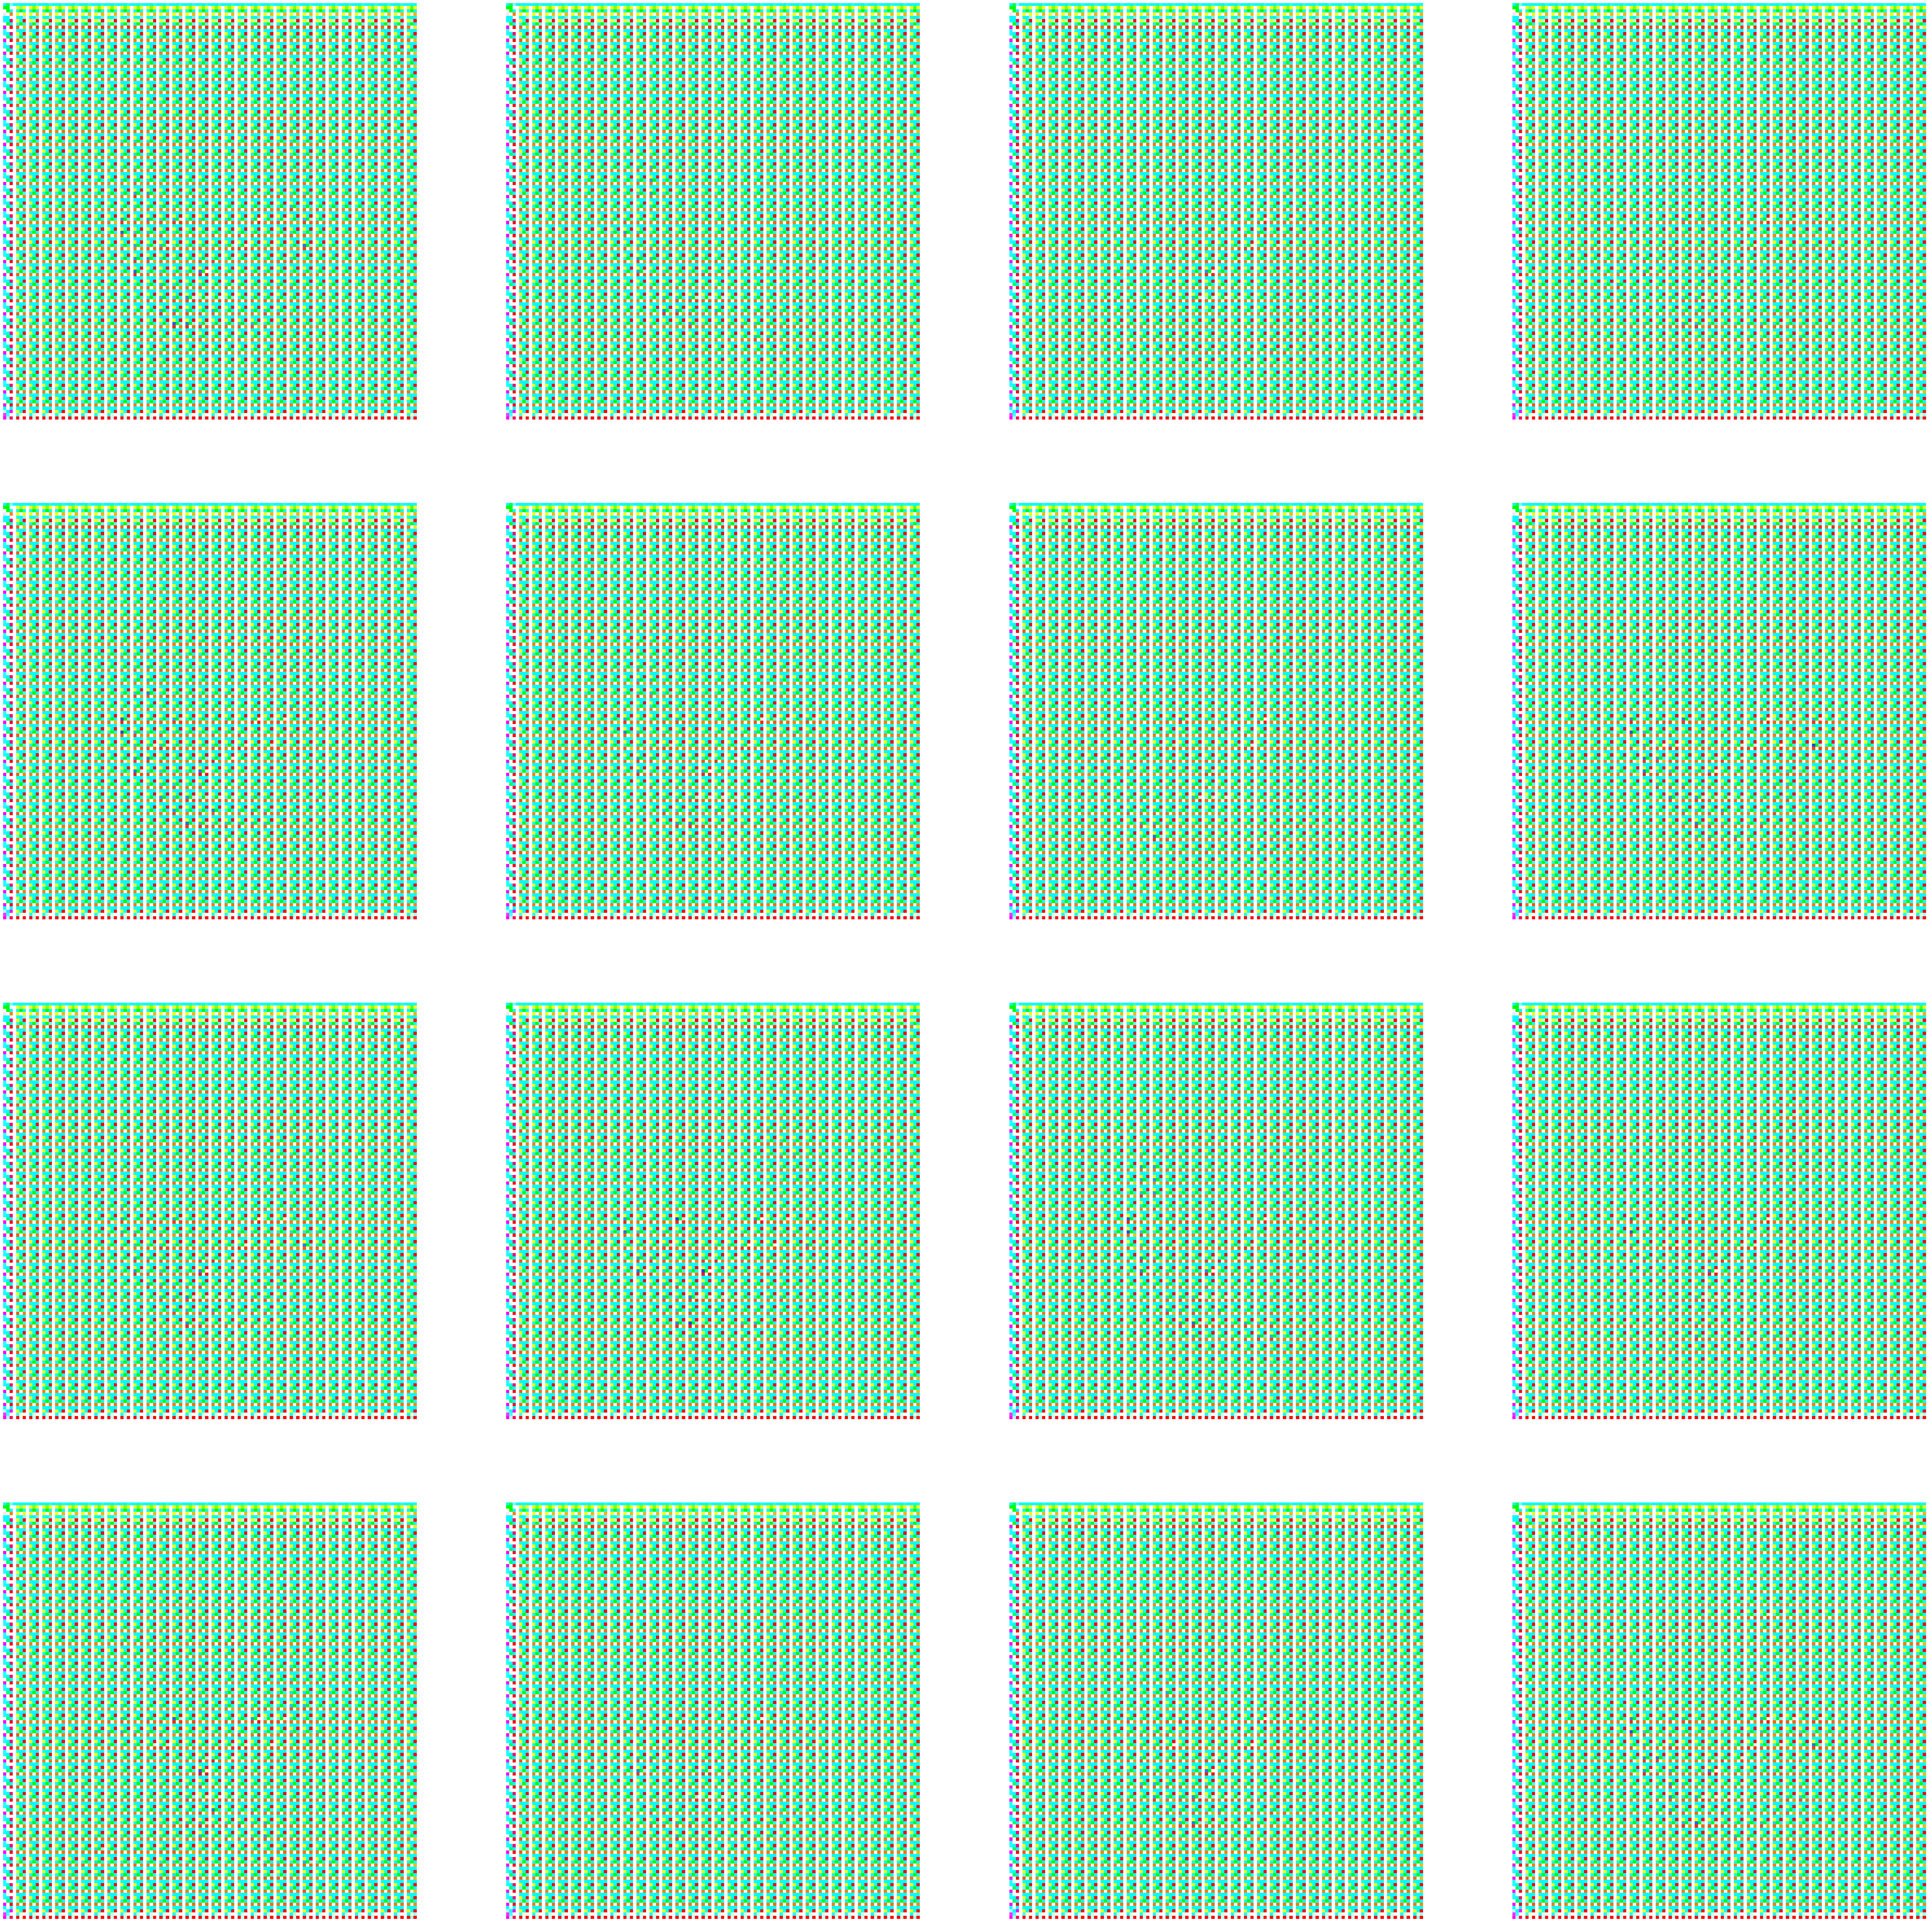

Time for epoch 30 is 413.9983012676239 sec


In [26]:
train(train_ds, 200)

In [23]:
generator.save("D:/models/cartoon_generator")
discriminator.save("D:/models/cartoon_discriminator")

INFO:tensorflow:Assets written to: D:/models/cartoon_generator\assets


INFO:tensorflow:Assets written to: D:/models/cartoon_generator\assets


INFO:tensorflow:Assets written to: D:/models/cartoon_discriminator\assets


INFO:tensorflow:Assets written to: D:/models/cartoon_discriminator\assets


In [24]:
i1 ,i2 =next(iter(val_ds))

NameError: name 'val_ds' is not defined

In [ ]:
i1.shape

In [ ]:
color.rgb2lab( color.gray2rgb(i1[i].numpy()[:,:,0]))[:,:,:1].shape

In [ ]:
generate_and_save_images(generator,1,i1,i2)

In [ ]:
output = generator(i1, training = False)
print(output.shape)

In [ ]:
# test with sample image 
face_path = "D:/data/faces/obama.jpg"

img1, img2 = get_segmented_image(face_path)

In [ ]:
img2 = tf.expand_dims(img2, axis = 0)

In [ ]:
out = generator(img2, training = False)
out.shape

In [ ]:
imgL = color.rgb2lab( color.gray2rgb(img[0].numpy()[:,:,0]))[:,:,:1]
# print(imgL.shape,predictions[i].shape)
imgout =  np.dstack((imgL,out[0]))
imgout = color.lab2rgb(imgout)

In [ ]:
plt.imshow(imgL)

In [ ]:


lab2color = color.lab2rgb(i2[0])

plt.imshow(lab2color)